In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import community
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import random
import copy

from statistics import mean
from collections import Counter
from collections import defaultdict
from deap import base
from deap import creator
from deap import tools

In [30]:
threshold = 0.6
egoradius = 3

# AMARE - Attribute-aware MARginalization Estimator

In [32]:
g = nx.Graph()
g.name = 'copenhagen'
with open('bt_symmetric.csv') as f:
    for l in f.readlines()[1:]:
        tid, a, b, rssi = l.rstrip().split(',')
        g.add_edge(int(a),int(b), tid=tid)
print('loaded')

attrs = {n: None for n in g.nodes()} # also fix missing data
with open('genders.csv') as f:
    for l in f.readlines()[1:]:
        node, gender = l.rstrip().split(',')
        attrs[int(node)] = gender
    nx.set_node_attributes(g, attrs, name='gender')
print('attributes')

loaded
attributes


In [33]:
to_remove = []
for n in attrs:
    if attrs[n] is None:
        to_remove.append(n)

g.remove_nodes_from(to_remove)

In [34]:
print(nx.info(g))

Name: copenhagen
Type: Graph
Number of nodes: 673
Number of edges: 75124
Average degree: 223.2511


In [35]:
attrs = nx.get_node_attributes(g, 'gender')

In [36]:
#g = nx.convert_node_labels_to_integers(g)
sizes = dict(Counter(list(nx.get_node_attributes(g, 'gender').values())))
sizes['0'] = sizes['0'] / (len(g))
sizes['1'] = sizes['1'] / (len(g))

In [37]:
weights = dict(Counter(list(nx.get_node_attributes(g, 'gender').values())))
weights['0'] = 1 - sizes['0']
weights['1'] = 1 - sizes['1']

In [38]:
def homogeneity(node, attr, center=True):
    
    egonet = nx.ego_graph(g, node, center=center)
    egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
    count = dict(Counter(egonet_attrs))[attr]
    size = len(egonet)
    if size > 2:
        return count/size


In [39]:
marg_dict = dict()

for node in list(g.nodes()):
    attr = attrs[node]
    
    # COMPUTE MARGINALIZATION
    marg = 0
    egonet = nx.ego_graph(g, node, center=True)
    egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
    
    #try
    count = dict(Counter(egonet_attrs))[attr]
    #except:
    #count = 0
    
    size = len(egonet)
    if size > 2:
        marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
    else:
        marg = 0
    
    marg_dict[node] = marg

disc_nodes = [k for k,v in marg_dict.items() if abs(v) > threshold]
disc = len(disc_nodes)

In [40]:
plausible = nx.Graph() # stores plausible links

for node in disc_nodes:
    egonet = nx.ego_graph(g, node, center=True)
    egonet2 = nx.ego_graph(g, node, center=True, radius=egoradius)
    egonet2.remove_nodes_from(egonet)
    for n in egonet2.nodes():
        if node != n and n in disc_nodes:
            if marg_dict[node] > 0:
                if attrs[n] != attrs[node]:
                    plausible.add_edge(node, n)
            elif marg_dict[node] < 0:
                if attrs[n] == attrs[node]:
                    plausible.add_edge(node, n)         
            else:
                print ("ERROR")
                
links = list(plausible.edges)

=== STATS ===
Marginalized nodes: 9
Global Discrimination: 1.337295690936107
Overall Marginalization Score: 0.1129377217024731


<AxesSubplot:ylabel='Density'>

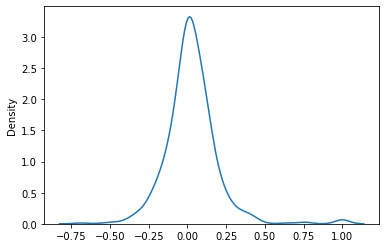

In [41]:
print("=== STATS ===")
print("Marginalized nodes:", disc)
print("Global Discrimination:", disc * 100 / len(g.nodes()))
print("Overall Marginalization Score:", mean([abs(x) for x in marg_dict.values()]))
sns.kdeplot(list(marg_dict.values()))

# MARK - MArginalization Reducer using linK

In [25]:
def random_individual(links):
    
    individual = []
    
    for e in links:
        individual.append(random.randint(0,1))
    
    return individual 

In [15]:
def evaluate(individual, g):
    
    eva = 0
    
    eva_g = copy.deepcopy(g)
    
    individual = individual[0] #<- because DEAP
    
    index = [i for i, j in enumerate(individual) if j == 1]

    new_links = [links[i] for i in index]

    #print (new_links)
    for l in new_links:
        eva_g.add_edge(l[0], l[1])
            
    for node in disc_nodes:
        marg = 0
        egonet = nx.ego_graph(eva_g, node, center=True)
        egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
        #try:
        count = dict(Counter(egonet_attrs))[attr]
        #except:
         #   count = 0
        
        size = len(egonet)
        if size > 2:
            marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
            if abs(marg) > threshold:
                eva = eva+1
                
        
    budget = sum(individual)
            
    return eva, budget, 

    #Fitness 1: nodi marginalizzati rimasti
    #Fitness 2: link usati
    
    #A parità di nodi marginalizzati (il meno possibile), la soluzione con meno link usati è la migliore

In [16]:
creator.create("Fitness", base.Fitness, weights=(-1.0,-1.0)) # <- -1 perché vogliamo minimizzare la fitness
creator.create("Individual", list, fitness=creator.Fitness) #<- l'individuo è definito come lista

toolbox = base.Toolbox() #creiamo il toolbox

toolbox.register("random_individual", random_individual, links) 
#"nome_della_funzione per deap", nome_della_funzione vera e propria di python, parametri che passi alla funzione

toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.random_individual, n=1) 
# n = numero di individui nella popolazione. Lasciamo 1

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate, g=g) #funzione di valutazione. Vedi quanto detto sopra
toolbox.register("mate", tools.cxTwoPoint) #funzione di crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) #funzione di mutazione custom
toolbox.register("select", tools.selTournament, tournsize=3)
#tools.selNSGA2) #funzione di selezione

Marginalized nodes: 42 · Available links: 465
gen	nevals	min	avg    
0  	150   	12 	17.5067
1  	91    	12 	16.1733
2  	88    	11 	15.2133
3  	81    	11 	14.1733
4  	92    	11 	13.4467
5  	93    	10 	12.8267
6  	83    	10 	12.2667
7  	93    	9  	12.0467
8  	94    	9  	11.5133
9  	105   	9  	11.36  
10 	88    	9  	10.8067
11 	92    	9  	10.34  
12 	93    	8  	10.1733
13 	103   	8  	10.0133
14 	92    	8  	9.8    
15 	103   	8  	9.75333
16 	102   	7  	9.40667
17 	93    	7  	9.14   
18 	87    	7  	8.80667
19 	84    	7  	8.74   
20 	93    	7  	8.60667
21 	97    	7  	8.66   
22 	92    	7  	8.32667
23 	105   	7  	8.04667
24 	94    	7  	7.95333
25 	104   	7  	7.94   
26 	97    	6  	7.92   
27 	105   	6  	7.85333
28 	95    	6  	7.68   
29 	107   	6  	7.69333
30 	94    	6  	7.69333
31 	91    	6  	7.52   
32 	97    	6  	7.20667
33 	93    	6  	7.18   
34 	107   	6  	7.00667
35 	97    	6  	6.72   
36 	94    	6  	6.70667
37 	97    	6  	6.87333
38 	97    	6  	6.89333
39 	103   	6  	7.02   
40 	94    	

<Figure size 432x288 with 0 Axes>

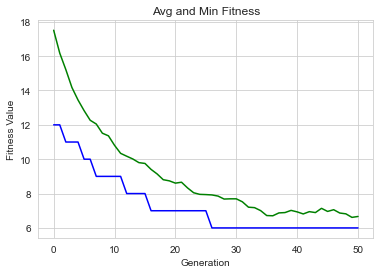

In [17]:
#def GA():
print ('Marginalized nodes:', disc, '· Available links:', len(links))
NUM_GENERATIONS = 50 #numero di generazioni
POPULATION_SIZE = 150 #popolazione per gen

CXPB, MUTPB = 0.5, 0.25 #crossover e mutation probability

n_HOF = 10 #top soluzioni da ritornare (la "Hall of Fame" di DEAP è il set di tutte le top n soluzioni)

pop = toolbox.population(n=POPULATION_SIZE)

hof = tools.HallOfFame(n_HOF)

stats = tools.Statistics(lambda ind: ind.fitness.values[0])   
stats.register('min', np.min, axis = 0)
stats.register('avg', np.mean, axis = 0)

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields

invalid_individuals = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_individuals)
for ind, fit in zip(invalid_individuals, fitnesses):
    ind.fitness.values = fit

hof.update(pop)
hof_size = len(hof.items)

record = stats.compile(pop)
logbook.record(gen=0, best="-", nevals=len(invalid_individuals), **record)
print(logbook.stream)

for gen in range(1, NUM_GENERATIONS + 1):

            # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))


    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1[0], child2[0])
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant[0])
            del mutant.fitness.values


    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the generated individuals
    hof.update(offspring)

    # Replace the current population by the offspring
    pop[:] = offspring

    # Append the current generation statistics to the logbook
    record = stats.compile(pop) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    print(logbook.stream)


hof.update(pop) # la HoF è aggiornata con la nuova popolazione (o meglio, i suoi individui migliori w.r.t. fitness)

plt.figure(1)

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
#plt.plot(maxFitnessValues, color='red')
plt.plot(minFitnessValues, color='blue')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.title('Avg and Min Fitness')
# show both plots:
plt.show()


#return hof.items

In [18]:
for e in hof.items:
    print ('Marginalized nodes:', e.fitness.values[0], '· Links:', e.fitness.values[1])
    print (e[0])
    print ("")

Marginalized nodes: 6.0 · Links: 208.0
[0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 

In [19]:
best = hof.items[0][0]

index = [i for i, j in enumerate(best) if j == 1]

new_links = [links[i] for i in index]

new_links

[(8, 174),
 (8, 477),
 (8, 484),
 (8, 571),
 (8, 707),
 (8, 355),
 (8, 426),
 (8, 463),
 (8, 496),
 (8, 392),
 (112, 33),
 (112, 213),
 (112, 234),
 (112, 343),
 (112, 426),
 (112, 590),
 (112, 124),
 (112, 251),
 (112, 346),
 (112, 654),
 (112, 573),
 (112, 460),
 (112, 392),
 (112, 174),
 (174, 484),
 (174, 562),
 (174, 707),
 (174, 234),
 (174, 319),
 (174, 393),
 (174, 410),
 (174, 417),
 (174, 620),
 (174, 77),
 (174, 654),
 (174, 460),
 (477, 125),
 (477, 343),
 (477, 213),
 (477, 347),
 (477, 426),
 (477, 463),
 (477, 565),
 (477, 590),
 (477, 649),
 (477, 77),
 (477, 124),
 (477, 526),
 (477, 460),
 (484, 343),
 (484, 347),
 (484, 426),
 (484, 565),
 (484, 590),
 (484, 649),
 (484, 77),
 (484, 251),
 (484, 496),
 (484, 526),
 (484, 573),
 (484, 460),
 (484, 695),
 (562, 125),
 (562, 343),
 (562, 33),
 (562, 233),
 (562, 426),
 (562, 620),
 (562, 251),
 (562, 346),
 (562, 526),
 (562, 460),
 (571, 343),
 (571, 565),
 (571, 426),
 (571, 251),
 (707, 234),
 (707, 319),
 (707, 565)

Random Benchmark

In [26]:
rans = []
c = 0
print ("Marginalized nodes:", end = ' ')
while c < 100:
    ran = random_individual (links)
    print (evaluate([ran], g)[0], end = ' ')
    rans.append(evaluate([ran], g)[0])
    c = c+1
print("")
print("")
print("Avg:", mean(rans), "· Min:", min(rans))

Marginalized nodes: 13 19 18 14 18 16 17 16 19 14 18 18 20 20 17 16 18 20 17 20 14 15 18 16 14 19 20 18 19 19 16 19 14 18 14 18 18 15 17 19 18 18 18 19 17 19 17 18 17 17 19 19 17 16 20 17 14 14 18 18 17 21 19 17 15 16 16 19 17 15 18 15 15 18 14 14 15 16 19 19 15 14 19 19 16 15 20 17 17 20 17 14 16 17 17 18 16 19 20 17 

Avg: 17.16 · Min: 13
